In [1]:
import math
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from utils import sprt_mart, get_eb_p_value, eb_selector, psi_E, v_i, pm_lambda
np.random.seed(123456789)

In [2]:
#stratum_1 = np.maximum(0, np.minimum(np.random.normal(loc = 0.5, scale = 0.05, size = 500), 1))
#stratum_2 = np.maximum(0, np.minimum(np.random.normal(loc = 0.8, scale = 0.05, size = 500), 1))
#stratum_3 = np.maximum(0, np.minimum(np.random.normal(loc = 0.4, scale = 0.05, size = 50), 1))
stratum_1 = np.ones(500) * 0.5
stratum_2 = np.ones(500) * 0.8
stratum_3 = np.ones(500) * 0.3
strata = [stratum_1, stratum_2, stratum_3]
np.mean(np.concatenate(strata))

0.5333333333333333

In [3]:
log_mart, p_value, selected_strata, eta_star_mat, running_a, running_b = get_eb_p_value(strata = strata, gamma = 1)

/Users/Jake/Dropbox/RLAs/alpha/Code/utils.py:514: RuntimeWarning: divide by zero encountered in true_divide
  lam_pm = np.sqrt(2 * np.log(1/alpha) / (lag_sigma_hat**2 * j * np.log(1 + j)))


In [4]:
running_a

array([187.5       , 271.36675375,  99.77411278])

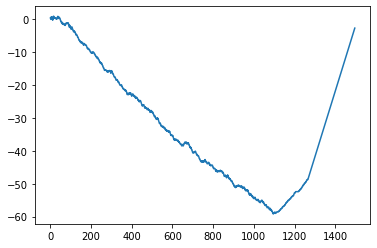

In [5]:
plt.plot(log_mart)

In [13]:
gamma = 1
run_in = 10
lam = np.array([.5, .5, .5])
#lam = None
N = np.array([len(x) for x in strata])
K = len(strata)
w = N/np.sum(N)
u = 1
marts = [np.ones(x) for x in N]
if lam is None:
    lam = [pm_lambda(stratum) for stratum in strata]
else:
    lam = [np.repeat(lam[k], N[k]) for k in np.arange(K)]
a = [np.cumsum(lam[k]*strata[k] - psi_E(lam[k])*v_i(strata[k])) for k in np.arange(K)]
running_n = np.zeros(K)
running_a = np.zeros(K)
running_b = np.zeros(K)
running_lam = np.array([x[0] for x in lam])
#record which strata are pulled from
selected_strata = np.zeros(np.sum(N) - K)
log_mart = np.zeros(np.sum(N) - K)
eta_star_mat = np.zeros((np.sum(N) - K, K))
i = 0
while any(running_n < (N-1)):
    next_stratum = eb_selector(running_a = running_a, running_n = running_n, running_b = running_b, run_in = run_in, N = N, gamma = gamma)
    selected_strata[i] = next_stratum
    running_n[next_stratum] += 1
    running_lam[next_stratum] = lam[next_stratum][int(running_n[next_stratum])]
    running_a[next_stratum] = a[next_stratum][int(running_n[next_stratum])]
    running_b[next_stratum] -= running_lam[next_stratum]
    eta_star = np.zeros(K)
    active = np.ones(K)
    #greedy algorithm to optimize over eta
    while((np.dot(eta_star, w) < 1/2) and all(eta_star <= u)):
        weight = -running_b / w
        max_index = np.argmax(weight * active)
        active[max_index] = 0
        eta_star[max_index] = np.minimum(u, (1/2 - np.dot(eta_star, w)) / w[max_index])
    log_mart[i] = np.sum(running_a) + np.dot(running_b, eta_star)
    eta_star_mat[i,:] = eta_star
    i += 1
    #print(w/running_b / np.sum(w/running_b), running_a / sum(running_a), running_n, eta_star, log_mart[i-1])
    print((running_a / running_n) / np.sum(running_a / running_n), running_n, eta_star, log_mart[i-1])
    
    
mart = np.exp(log_mart)
p_value = 1/np.maximum(1, mart)

[nan nan nan] [0. 0. 1.] [0.5 0.  1. ] -0.21545177444479563
[nan nan nan] [0. 0. 2.] [0.5 0.  1. ] -0.5731776616671934
[nan nan nan] [0. 1. 2.] [0.  0.5 1. ] -0.057944154167983486
[nan nan nan] [0. 1. 3.] [0.  0.5 1. ] -0.41567004139038133
[nan nan nan] [0. 1. 4.] [0.  0.5 1. ] -0.7733959286127792
[nan nan nan] [0. 1. 5.] [0.  0.5 1. ] -1.131121815835177
[nan nan nan] [0. 2. 5.] [0.  0.5 1. ] -0.998505062085572
[nan nan nan] [0. 3. 5.] [0.  0.5 1. ] -0.865888308335967
[0.4234114  0.43201145 0.14457715] [1. 3. 5.] [0.  0.5 1. ] -0.36588830833596697
[0.35515245 0.48315476 0.1616928 ] [2. 3. 5.] [0.  0.5 1. ] -0.11588830833596697
[0.3567548  0.48533462 0.15791058] [2. 3. 6.] [0.  0.5 1. ] -0.4736141955583646
[0.33020449 0.50536708 0.16442843] [3. 3. 6.] [0.5 0.  1. ] -0.2236141955583646
[0.34097432 0.48923432 0.16979136] [3. 4. 6.] [0.  0.5 1. ] -0.09099744180876002
[0.32662407 0.49988737 0.17348856] [4. 4. 6.] [0.5 0.  1. ] 0.15900255819123998
[0.31770998 0.50650484 0.17578519] [5. 4. 6.

/var/folders/zt/byjw_s1s4g5b01_cjmqw49480000gn/T/ipykernel_79358/4200616941.py:43: RuntimeWarning: invalid value encountered in true_divide
  print((running_a / running_n) / np.sum(running_a / running_n), running_n, eta_star, log_mart[i-1])


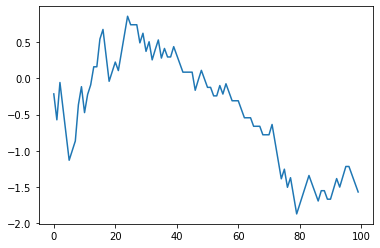

In [18]:
plt.plot(log_mart[0:100])